<a href="https://colab.research.google.com/github/saim-glitch/Freelancing/blob/main/NLP_Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk as nlp
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [27]:
fake_df = pd.read_csv("/content/Fake.csv")
true_df = pd.read_csv("/content/True.csv")

In [28]:
# Rows and columns of fake news dataset
print(f"Fake news dataset has: {fake_df.shape[0]} rows")
print(f"Fake news dataset has: {fake_df.shape[1]} columns")

Fake news dataset has: 23481 rows
Fake news dataset has: 4 columns


In [29]:
fake_df.isnull().sum()

,0
title,0
text,0
subject,0
date,0


In [30]:
true_df.isnull().sum()

,0
title,0
text,0
subject,0
date,0


In [32]:
fake_df['Fake'] = 1
true_df['True'] = 0
df = pd.concat([fake_df, true_df])

In [33]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month

# **EDA - Exploratory Data Analysis**

<Axes: xlabel='Fake', ylabel='count'>

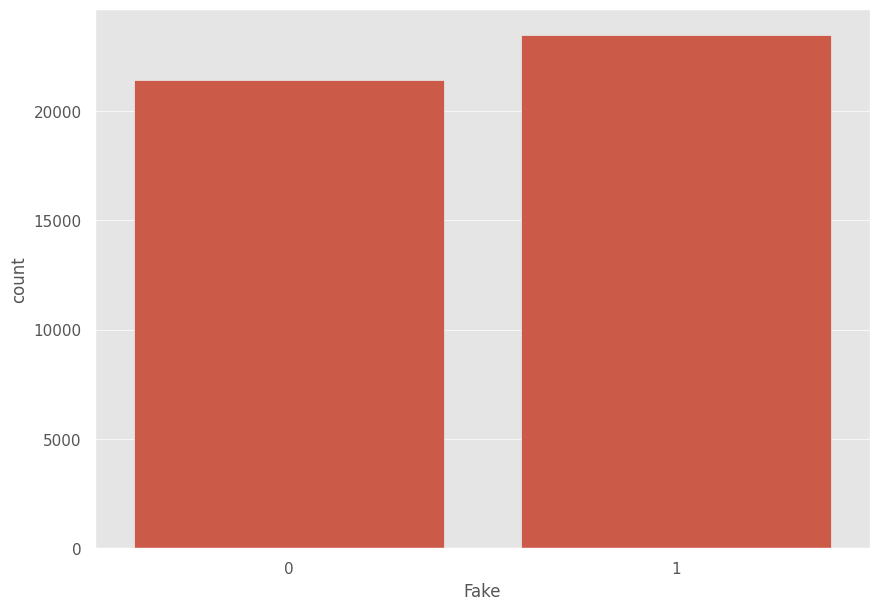

In [34]:
plt.style.use('ggplot')
plt.figure(figsize=(10,7))
sns.countplot(data=df, x='Fake')

In [35]:
print(df.columns)
print(df.columns[df.columns.duplicated()])


Index(['title', 'text', 'subject', 'date', 'Fake', 'True', 'Year', 'Month'], dtype='object')
Index([], dtype='object')


In [37]:
df = df.loc[:, ~df.columns.duplicated()]

In [39]:
df = df.reset_index(drop=True)


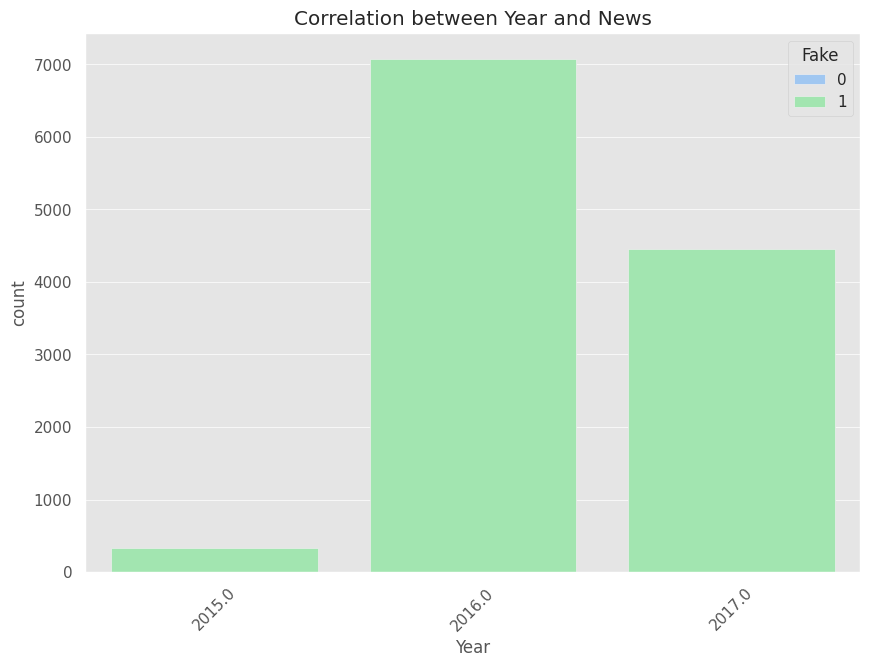

In [40]:
plt.style.use('seaborn-v0_8-pastel')

plt.figure(figsize=(10, 7))
sns.countplot(data=df, x='Year', hue='Fake')
plt.title("Correlation between Year and News")
plt.xticks(rotation=45)
plt.show()


<Axes: xlabel='Month', ylabel='count'>

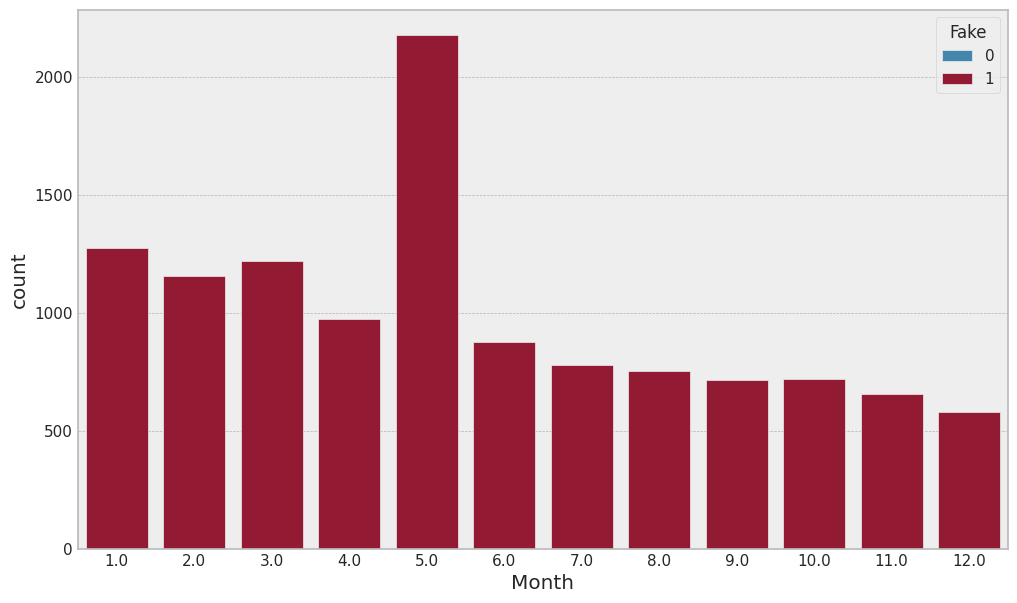

In [24]:
plt.style.use('bmh')
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='Month', hue='Fake')

In [41]:
df.subject.value_counts()

,count
subject,
politicsNews,11272
worldnews,10145
News,9050
politics,6841
left-news,4459
Government News,1570
US_News,783
Middle-east,778


<Axes: xlabel='Year', ylabel='count'>

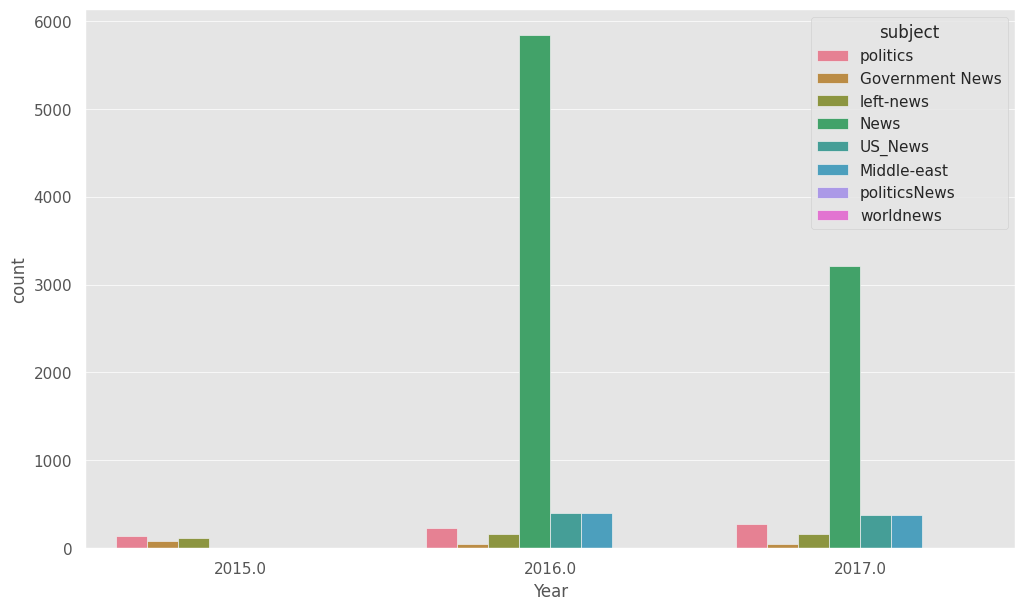

In [43]:
plt.style.use('seaborn-v0_8-pastel')
plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='Year', hue='subject')

In [44]:
nlp.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [45]:
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [46]:
# Joining the title and the content columns
df['full_text'] = df['title'] + ' ' + df['subject']

In [47]:
df.head()

,title,text,subject,date,Fake,True,Year,Month,full_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,1,NaN,2017.0,12.0,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,1,NaN,2017.0,12.0,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,1,NaN,2017.0,12.0,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,1,NaN,2017.0,12.0,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,1,NaN,2017.0,12.0,Pope Francis Just Called Out Donald Trump Dur...


In [48]:
# Target variable and features
y = df['Fake']
X = df.drop('Fake', axis=1)

In [49]:
# Stemming process
def stemming_process(y):
    first_step = re.sub(r"^[A-Za-z]", ' ', y).lower()
    second_step = first_step.split()
    porter_stemmer = PorterStemmer()
    result = []
    for w in second_step:
        if w not in stopwords.words('english'):
            result.append(porter_stemmer.stem(w))
    return ' '.join(result)

In [50]:
df['full_text'] = df['full_text'].apply(stemming_process)

In [51]:
# Converting X and y to numpy arrays
X = df['full_text'].to_numpy()
y = df['Fake'].to_numpy()

In [52]:
# Converting the text into numerical values
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)

In [53]:
# Building the model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [54]:
# Fitting the model - Logistic Regression
lg = LogisticRegression()
lg.fit(X_train, y_train)

LogisticRegression()

In [55]:
# Predictiion
prediction = lg.predict(X_test)

In [56]:
# Score
accuracy = accuracy_score(prediction, y_test)
print(f"Model precision: {accuracy}")

Model precision: 0.9998218262806237
